
# Photon Time Propagation Study 
## Goals:
### 1. Filter L1 for extreme TDC values and rerun L1Ch6 regression 
### 2. Repeat for each channel in L1/L3 

In [1]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
import PyPDF2

In [2]:
from MuDataFrame import *
import numpy as np
from scipy import stats

mdfo_calib = MuDataFrame("/Volumes/DAQ/PhotonTimeProp/dataFiles/calibration_new_set_up.csv")

mdf_calib = mdfo_calib.events_df
mdfo_calib.keep4by4Events()
mdfo_calib.og_df = mdf_calib.copy()
mdfo_calib.show()

,Unnamed: 0,index,event_num,event_time,deadtime,l1hit,l2hit,l3hit,l4hit,r1hit,...,z_angle,SmallCounter,speed,Run_Num,xx,yy,xx1,yy1,time_of_day,time
0,0,0,0,2021-05-03 12:40:15.812760,0,1.0,1.0,1.0,1.0,1.0,...,13.455446,NaN,0.342978,622,-5.445887,-22.562492,-6.807692,-22.684615,day,0
1,1,1,1,2021-05-03 12:40:16.502963,0,1.0,1.0,1.0,1.0,1.0,...,12.002813,NaN,0.703353,622,-11.762760,-21.506829,-11.538462,-21.784615,day,690203
2,2,2,2,2021-05-03 12:40:16.672924,0,1.0,1.0,1.0,1.0,1.0,...,14.672630,NaN,0.210716,622,35.347122,13.620282,36.676923,14.884615,day,860164
3,3,3,3,2021-05-03 12:40:16.892987,0,1.0,1.0,1.0,1.0,1.0,...,15.284964,NaN,0.259347,622,24.903617,25.826667,27.746154,29.153846,day,1080227
4,4,4,4,2021-05-03 12:40:17.563102,0,1.0,1.0,1.0,1.0,1.0,...,4.253100,NaN,11.038012,622,6.978340,14.482143,7.676923,15.230769,day,1750342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2999992,2999992,99992,2999992,2021-05-20 13:18:29.305435,0,1.0,1.0,1.0,1.0,1.0,...,4.471381,NaN,2.208244,656,-24.827750,-14.125268,-25.330769,-14.146154,day,1077344492675
2999993,2999993,99993,2999993,2021-05-20 13:18:29.875548,0,1.0,1.0,1.0,1.0,1.0,...,15.702291,NaN,0.346495,656,13.468468,-38.856563,13.800000,-37.423077,day,1077345062788
2999994,2999994,99994,2999994,2021-05-20 13:18:30.125522,0,1.0,1.0,1.0,1.0,1.0,...,13.684312,NaN,0.276322,656,28.348837,-29.674472,28.130769,-29.230769,day,1077345312762
2999996,2999996,99996,2999996,2021-05-20 13:18:30.965416,0,1.0,1.0,1.0,1.0,1.0,...,6.035804,NaN,0.442759,656,12.892377,-12.244589,13.269231,-13.276923,day,1077346152656


## Next 2 cells get peaks coordinates and append them to a list for each layer
## repeat for each layer

In [3]:
def getIntersections(t, curve1, curve2, doPlot=True):
    intersections = []
    xvals = []
    prev_dif = 0
    t0, prev_c1, prev_c2 = None, None, None
    for t1, c1, c2 in zip(t, curve1, curve2):
        new_dif = c2 - c1
        if np.abs(new_dif) < 1e-12:  # found an exact zero, this is very unprobable
            intersections.append((t1, c1))
        elif new_dif * prev_dif < 0:
            denom = prev_dif - new_dif
            xvals.append((-new_dif * t0 + prev_dif * t1) / denom)
            intersections.append(((-new_dif * t0 + prev_dif * t1) / denom,
                                  (c1 * prev_c2 - c2 * prev_c1) / denom))
        t0, prev_c1, prev_c2, prev_dif = t1, c1, c2, new_dif

    if doPlot:
        fig, ax = plt.subplots()
        ax.plot(t, curve1, 'b-')
        ax.plot(t, curve2, 'r-')
        ax.plot(*zip(*intersections), 'kx', ms=5)
        plt.show()
    
    diffs = np.diff(xvals)
    return xvals

In [ ]:
from scipy.stats import gaussian_kde
mdfo_calib.reload()
mdfo_calib.keep4by4Events()
data = mdfo_calib.get("diffL1")
bandwidth = 0.02
density1 = gaussian_kde(data, bw_method=bandwidth)
xs = np.linspace(-75,75,150)
t = xs
curve1 = density1(xs)
curve2 = len(curve1) * [0.00135]
vals = getIntersections(t, curve1, curve2)
L1cuts = np.reshape(vals,[11,2])
L1cuts = np.flip(L1cuts,0)

### Difference between L1 and R1 TDC values

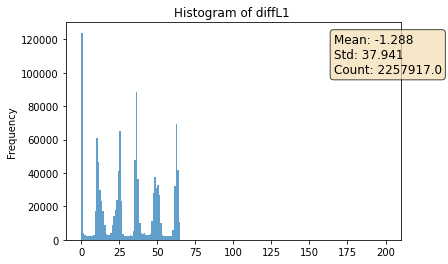

In [4]:
mdfo_calib.getHistogram("diffL1",range=(0,200))

### Next 3 cells create list of TDC values for every event through each channel in L1/L3, then computes the mean TDC count for each channel

In [ ]:
#get TDC means for each channel in L1/L3 --> independent variable for regression
def getSingleLayerData(data, layer, peaks):
    diff = "diffL" + str(layer)
    final = "L" + str(layer)
    TDCS_List = []
    for each_peak in peaks:
        data.reload()
        data.keep4by4Events()
        #data.keepEvents("z_angle",9.391,"<=")
        data.keepEvents(diff, each_peak[1],"<=")
        data.keepEvents(diff, each_peak[0],">=")
        # store the tdcs
        TDCS_List.append(data.get(diff))
    return TDCS_List

In [ ]:
L1_TDCraw = getSingleLayerData(mdfo_calib, 1, L1cuts)
L3_TDCraw = getSingleLayerData(mdfo_calib, 3, L3cuts)

In [ ]:
L1_means = []
L3_means = []

for i, j in zip(L1_TDCraw, L3_TDCraw):
    temp1 = stats.describe(i)
    temp3 = stats.describe(j)
    L1_means.append(round(temp1[2],3))
    L3_means.append(round(temp3[2],3))
    
    
#Important step in order to use in regression
L1_means = np.asarray(L1_means).reshape((11,1))
L3_means = np.asarray(L3_means).reshape((11,1))

### Next 2 cells create a list for L1/L3 with each element holding a list of TDC values for events that went through L1/L3 Ch6 and every channel in L2/L4

In [5]:
def getChData(data, ch, topPeaks, botPeaks):
    i = 0
    TDCS_List = []

    topDiff = "diffL" + str(ch)
    botDiff = "diffL" + str(ch+1)
    final = "L" + str(ch)
    for each_peak in botPeaks:
        #print(i)
        #i+=1
        data.reload()
        data.keep4by4Events()
        #data.keepEvents("z_angle",9.391,"<=")
        data.keepEvents(topDiff,topPeaks[1],"<=")
        data.keepEvents(topDiff,topPeaks[0],">=")

        data.keepEvents(botDiff,each_peak[1],"<=")
        data.keepEvents(botDiff,each_peak[0],">=")
        # store the tdcs
        TDCS_List.append(data.get(final))
    return TDCS_List

### Create linear regression for L1/L3

In [ ]:
#Get TDC dist only from L1/L3 Ch6 and onto each channel in L2/L4 (0-10)
TDCS_L1Ch6_L2 = getChData(mdfo_calib, 1, L1cuts[5], L2cuts)
TDCS_L3Ch6_L4 = getChData(mdfo_calib, 3, L3cuts[5], L4cuts)

#Get TDC means of L1/L3 Ch6 onto each channel in L2/L4
L1Ch6_L2_TDCmeans = []
L1Ch6_L2_TDCstds = []

L3Ch6_L4_TDCmeans = []
L3Ch6_L4_TDCstds = []


for i, j in zip(TDCS_L1Ch6_L2, TDCS_L3Ch6_L4):
    temp1 = stats.describe(i)
    temp3 = stats.describe(j)
    L1Ch6_L2_TDCmeans.append(round(temp1[2],3))
    L1Ch6_L2_TDCstds.append(round(np.sqrt(temp1[3]),3))
    L3Ch6_L4_TDCmeans.append(round(temp3[2],3))
    L3Ch6_L4_TDCstds.append(round(np.sqrt(temp3[3]),3))
    
yrange = [5*i-2.5 for i in range(1,12)]

### Reload dataset making cuts for testing regression on L1Ch6 events

In [ ]:
mdfo_calib.reload()
mdfo_calib.keep4by4Events()
mdfo_calib.keepEvents("z_angle", 9.391,"<=")
mdfo_calib.keepEvents("diffL1",L1cuts[5][0],">=")
mdfo_calib.keepEvents("diffL1",L1cuts[5][1],"<=")
mdfo_calib.show()

## Create dataframe holding regression predictions and relevant information

In [7]:
def testPred(layer, TDC):
    test = np.array(TDC).reshape(-1,1)
    if layer==1: 
        return reg1.predict(test)
    else: 
        return reg3.predict(test)

In [ ]:
#[TDC, y (cm), ypred]
ySet = []
for i in range(1000):
    Y1 = testPred(1, mdfo_calib.events_df.L1.values[i])[0]
    Y2 = testPred(3, mdfo_calib.events_df.L3.values[i])[0]
    Ypred = (42 *(Y1-Y2))/65 + Y1
    ySet.append([mdfo_calib.events_df.L1.values[i], mdfo_calib.events_df.L3.values[i], Y1, Y2, mdfo_calib.events_df.yy1.values[i], Ypred])
    
YPred_df = pd.DataFrame(ySet, columns = ['L1 TDC', 'L3 TDC', 'Y1pred', 'Y2pred', 'Y_projected(cm)', 'Y_pred(cm)'])
YPred_df["error"] = ((YPred_df["Y_projected(cm)"] -  YPred_df["Y_pred(cm)"]) / YPred_df["Y_projected(cm)"])*100

## Filtering for +/- inifinity and null values

In [ ]:
YPred_df.replace([np.inf, -np.inf], np.nan, inplace=True)
YPred_df_filtered = YPred_df[YPred_df["error"].notnull()]

## Exploring error

In [ ]:
YPred_df_filtered.error.plot(kind="hist",bins=100)
plt.xlabel("Normalized Error",fontsize=12)
plt.title("Prediction vs Data -L1 Ch6 Events",fontsize=15)
plt.yscale("log")
#plt.xscale("log")

## Creating dataframe to hold stats

In [ ]:
L1Ch6Stats = YPred_df_filtered.describe()
L1Ch6Stats

In [ ]:
#L1Ch6Stats.to_pickle("/Volumes/DAQ/PhotonTimeProp/L1Ch6Stats_z3.pkl")
#YPred_df_filtered.to_pickle("/Volumes/DAQ/PhotonTimeProp/YPredsDF_z<5.pkl")